<a href="https://colab.research.google.com/github/kmrakovcic/FoP_ML_workshop23/blob/master/02_fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fitting

Curve fitting is a type of optimization that finds an optimal set of parameters for a defined function that best fits a given set of observations.

Unlike supervised learning, curve fitting requires that you define the function that maps examples of inputs to outputs.

The mapping function, also called the basis function can have any form you like, including a straight line (linear regression), a curved line (polynomial regression), and much more. This provides the flexibility and control to define the form of the curve, where an optimization process is used to find the specific optimal parameters of the function.

#Example 1
Given the data and the theoretical function, calculate parameters of that function.

First, we have to simulate some data. Imagine we are doing some experiment where $x$ is independent variable, and we know from theory that dependent variable that we measure must satisfy the law:
$$ y = a+b \cdot 10^{cx} $$

In reality let's say that the unknown parameters are:
* a=0.84
* b=0.34
* c=0.45

First step is to simulate the mesurements. Instead of generating perfect data, to faithfully recreate the mesuring process, a random Gaussian noise with $\sigma = 0.1$ is added.

Text(0, 0.5, 'y')

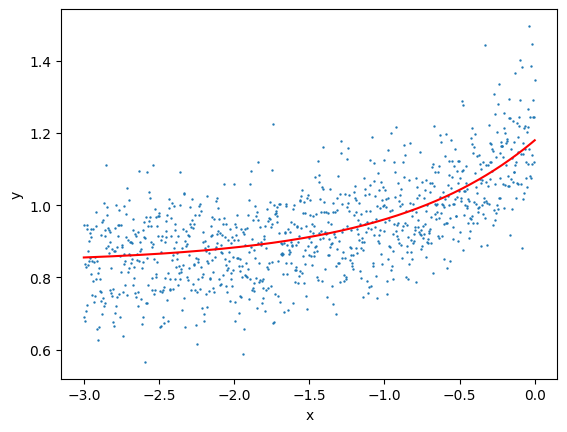

In [31]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

def data_generation (x):
    y = 0.84 + 0.34 * np.power(10, 0.45*x)
    return y+np.random.normal(0, 0.1, size=y.shape)

data_x = np.linspace (-3, 0,1000)
data_y = data_generation (data_x)
fig, ax = plt.subplots()
ax.scatter (data_x, data_y, s=0.5)
ax.plot (data_x, 0.84 + 0.34 * np.power(10, 0.45*data_x), color="red")
ax.set_xlabel("x")
ax.set_ylabel("y")

In statistics, maximum likelihood estimation (MLE) is a method of estimating the parameters of an assumed probability distribution, given some observed data. This is achieved by maximizing a likelihood function so that, under the assumed statistical model, the observed data is most probable.

Let's say that we know that some data were drawn from a Gaussian distribution, but we don't know the $\theta = (\mu,\sigma)$ values of that distribution (i.e., the parameters).

Then Maximum Likelihood Estimation method tells us to think of the likelihood as a ***function of the unknown model parameters***, and ***find those that maximize the value of $L$***. Those will be our Maximum Likelihood Estimators for for the true values of the model.

For a sample of $N$ data points, $\{x_i\}$, where the uncertainty for each measurement is Gaussian with
a known $\sigma$, the likelihood of all N measurements is

$$L \equiv p(\{x_i\}|\mu,\sigma) = \prod_{i=1}^N \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma^2}\right).$$

Keep in mind that $\mu$ here is a function we are trying to fit, $\mu = \mu (a,b,c)$. If we calculate logarithm of likelihood we get:
$$ \ln{L} = \sum_{i=1}^N \frac{-(x_i-\mu)^2}{2\sigma^2} \ln{\left(\frac{1}{\sigma\sqrt{2\pi}} \right)} $$
Under assumtion that all the mesurements are done with same uncertanty:
$$ \ln{L} = \left[ \frac{1}{2\sigma^2} \ln{\left(\frac{1}{\sigma\sqrt{2\pi}} \right)}\right]^N \sum_{i=1}^N -(x_i-\mu)^2$$

If we maximize that function actually we are maximizing:
$$ \ln{L} = - \sum_{i=1}^N (x_i-\mu)^2$$

Additionally for computational reasons, instead of maximizing, it is always better to minimize negative log likelihood:
$$ -\ln{L} = \sum_{i=1}^N (x_i-\mu)^2$$

In the machine learning this function is usually called **Mean square error** (MSE)

In [54]:
def teoretical_function(x, a, b, c):
    return a + b * np.power(10, c*x)

def neg_log_likelihood(x, y):
    def function(parm):
        a = parm[0]
        b = parm[1]
        c = parm[2]
        mu = a + b * np.power(10, c*x)
        return np.sum((y-mu)**2)
    return function

def maximum_likelihood_estimate(x, y):
    return scipy.optimize.minimize(neg_log_likelihood(x, y), [0.5, 0.5, 0.5], bounds=[(0, 1), (0, 1), (0, 1)])

MLE_object = maximum_likelihood_estimate(data_x, data_y)
a, b, c = MLE_object.x
print ("Value of a:", a)
print ("Value of b:", b)
print ("Value of c:", c)

Value of a: 0.838018797554989
Value of b: 0.3627280124499384
Value of c: 0.5105618568439171


How to get uncertanty estimates? Usual way is to use inverse hessian object, that on its diagonal has $\sigma$ values for all the parameters. Be aware this method is easy although it may not always work!

In [53]:
inv_hess = MLE_object.hess_inv.todense()
print (inv_hess)
print ("Value of a:", a, "+-", inv_hess[0,0])
print ("Value of b:", b, "+-", inv_hess[1,1])
print ("Value of c:", c, "+-", inv_hess[2,2])

[[5.51412705e-03 7.70528297e-05 2.72530399e-02]
 [7.70528297e-05 1.40728944e-02 1.92221536e-02]
 [2.72530399e-02 1.92221536e-02 1.74887990e-01]]
Value of a: 0.838018797554989 +- 0.005514127045732072
Value of b: 0.3627280124499384 +- 0.014072894426980814
Value of c: 0.5105618568439171 +- 0.17488799047722858


To plot the best fit and the data:

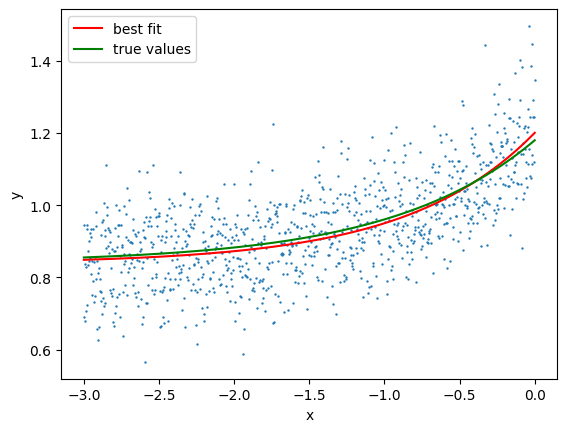

In [41]:
fig, ax = plt.subplots()
ax.scatter (data_x, data_y, s=0.5)
ax.plot (data_x, teoretical_function(data_x, a, b, c), color="red", label="best fit")
ax.plot (data_x, 0.84 + 0.34 * np.power(10, 0.45*data_x), color="green", label="true values")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.legend()

In [ ]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt


def neg_log_likelihood(x, lower_cutoff=0.75, higher_cutoff=9):
    """
    Function to calculate the negative log likelihood of the data given the parameters w and tau.
    :param x:
    :param lower_cutoff:
    :param higher_cutoff:
    :return:
    """
    def function(parm):
        """
        Function to calculate the negative log likelihood of the data given the parameters w and tau.
        :param parm:
        :return:
        """
        w = parm[0]
        tau = parm[1]
        y = w * 1/tau * 1/(np.exp(-lower_cutoff/tau)-np.exp(-higher_cutoff/tau)) * np.exp(-x/tau) + (1-w) * 1/(higher_cutoff-lower_cutoff)
        if np.any(y <= 0):
            return 1e10
        else:
            return -np.sum(np.log(y))
    return function


def exp_function(x, w, tau, lower_cutoff, higher_cutoff):
    """
    Function to calculate the data distribution model given the parameters w and tau.
    :param x:
    :param w:
    :param tau:
    :param lower_cutoff:
    :param higher_cutoff:
    :return:
    """
    y = w * 1/tau * 1/(np.exp(-lower_cutoff/tau)-np.exp(-higher_cutoff/tau)) * np.exp(-x/tau) + (1-w) * 1/(higher_cutoff-lower_cutoff)
    return y


def estimate_standard_deviation(data, params, lower_cutoff=0.75, higher_cutoff=9):
    """
    Estimate the standard deviation of the parameters using the fact that the likelihood function is a parabola
    around the maximum likelihood estimate. The standard deviation is the distance from the maximum likelihood
    estimate to the point where the likelihood function is 0.5 below the maximum likelihood estimate.
    :param data:
    :param params:
    :param lower_cutoff:
    :param higher_cutoff:
    :return:
    """
    likelihood = neg_log_likelihood(data, lower_cutoff, higher_cutoff)
    init_like = likelihood(params)
    p_err = np.zeros(len(params))
    for i,parameter in enumerate(params):
        for k in range(-1, 5):
            continue_l = True
            while continue_l:
                new_params = np.zeros(len(params))
                new_params[i] = p_err[i] + 10 ** (-k)
                new_params = new_params + params
                p_like = likelihood(new_params)
                if (p_like - init_like) >= 0.5 or np.isnan(p_like - init_like) or p_err[i] > 10:
                    continue_l = False
                else:
                    p_err[i] += 10 ** (-k)
    return p_err


def maximum_likelihood_estimate(data, lower_cutoff, higher_cutoff):
    """
    Function to calculate the maximum likelihood estimate of the parameters w and tau.
    :param data:
    :param lower_cutoff:
    :param higher_cutoff:
    :return:
    """
    popt = scipy.optimize.minimize(neg_log_likelihood(data, lower_cutoff, higher_cutoff), [0.5, 2], bounds=[(0, 1), (1, 3)])
    values = popt.x
    errors = estimate_standard_deviation(data, values, lower_cutoff, higher_cutoff)
    return values, errors


def fit_and_calculate_histogram(data, n_bins, lower_cutoff=0.75, higher_cutoff=9):
    """
    Function to calculate the histogram of the data and fit the data distribution model to the histogram.
    :param data:
    :param n_bins:
    :param lower_cutoff:
    :param higher_cutoff:
    :return:
    """
    data = data[np.logical_and(data < higher_cutoff, data > lower_cutoff)]
    [w, tau], [w_err, tau_err] = maximum_likelihood_estimate(data, lower_cutoff, higher_cutoff)
    counts, bins = np.histogram(data, bins=n_bins)
    data.sort()
    x_fit = data
    y_fit = exp_function(data, w, tau, lower_cutoff, higher_cutoff)
    return counts, bins, x_fit, y_fit, w, tau, w_err, tau_err


def update_histogram(ax, counts, bins, x_fit=None, y_fit=None):
    ax.clear()
    if x_fit is not None:
        counts = (counts / x_fit.size) / (bins[1] - bins[0])
    ax.bar(bins[:-1] + (bins[1] - bins[0]) / 2, counts, width=bins[1] - bins[0])
    if x_fit is not None and y_fit is not None:
        ax.plot(x_fit, y_fit, color="r")
    return ax


if __name__ == '__main__':
    #data = np.random.exponential(2, 1000)
    data = np.array(pd.read_csv('test_data.csv'))
    counts, bins, x_fit, y_fit, w, tau, w_err, tau_err = fit_and_calculate_histogram(data, 100)
    fig, ax = plt.subplots(2, 1)
    ax[0] = update_histogram(ax[0], counts, bins, x_fit, y_fit)
    plt.show()